In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [2]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

In [3]:
evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [5]:
# stolen from datapipes

from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )


def build_datasets_from_local(step: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(f"/home/tom/local_data/basic_processed_nwp_data_step_{step}.npy")
    X = pd.DataFrame(data=X.reshape(X.shape[1], X.shape[2]).T, columns=nwp.coords["variable"], index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    return X, y

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'n_estimators': 1500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss_mean: float
    mse_train_loss_std: float
    mse_test_loss_mean: float
    mse_test_loss_std: float
    mae_train_loss_mean: float
    mae_train_loss_std: float
    mae_test_loss_mean: float
    mae_test_loss_std: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   number_of_runs: int = 1,
                   train_test_split_fraction: float = 0.8,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG,
                   randomised_splitting: bool = False) -> ExperimentSummary:
    
    
    train_mse, train_mae, test_mse, test_mae = np.empty((4, number_of_runs))
    
    for run in range(number_of_runs):
        if randomised_splitting:
            # start with a randomised train/test split before structing a time-series specific one
            n = X.shape[0]
            train_idx = np.random.choice(np.arange(n), int(train_test_split_fraction*n), replace=False)
            test_idx = list(set(np.arange(n)).difference(train_idx))
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        else:
            # use 2020 as training period and 2021 as test
            X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
            X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]
        
        model = XGBRegressor(**booster_hyperparam_config)
        model.fit(X_train, y_train)
        
        y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
        train_mse[run], test_mse[run] = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
        train_mae[run], test_mae[run] = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        np.mean(train_mse),
        np.std(train_mse),
        np.mean(test_mse),
        np.std(test_mse),
        np.mean(train_mae),
        np.std(train_mae),
        np.mean(test_mae),
        np.std(test_mae),
        model  # just save the last trained model for nwo
    )
        

In [124]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this, the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y, 5, 0.8, randomised_splitting=True)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


In [8]:
import pickle

# with open('/home/tom/local_data/xgb_forecast_steps_v1_randomised.pkl', 'wb') as f:
#     pickle.dump(results, f)

with open('/home/tom/local_data/xgb_forecast_steps_v1_randomised.pkl', 'rb') as f:
    results = pickle.load(f)

### View the results of the model

With this model, we are modelling the PV output at multiple time-steps in the future using NWP forecasts. In particular, we model PV at $t + X$, using NWP forecasts of step $X$ at time $t$. Each time-step regression forecast models are independent (and they also have different covariates).

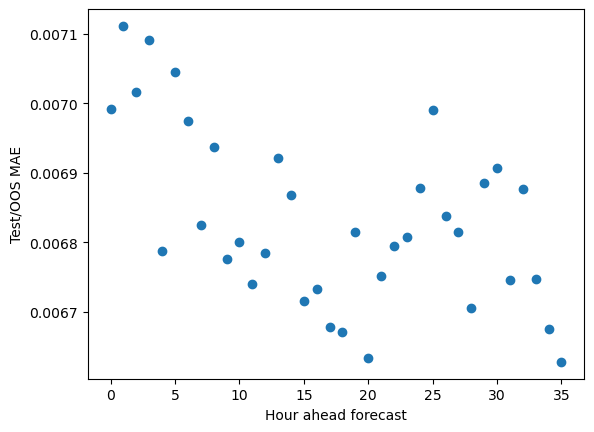

In [11]:
# plot the MAE of the OOS for each model
mae_test = pd.Series({step: r.mae_test_loss_mean for step, r in results.items()})
plt.scatter(mae_test.index, mae_test.values)
plt.ylabel("Test/OOS MAE")
plt.xlabel("Hour ahead forecast")
plt.show()

Comment: 
This is an interesting plot - we would expect a decay in performance as time increases (due to increasing uncertainity in the modelling of NWP) however here we see that model performance increases as the forcast horizon increases. This need further investigation, it could be that the very short term horizon NWP forecasts are too noisy and so the model performs worse. There could also be some data leakage due to the randomised splitting in time-space, this will be addressed in my next notebook.

In [14]:
# quick sanity check that the model using NWP @ t is better than @ t+X

_model = results[0].model  # take the model at t=0
tstep_error = dict()

# for each forecast horizon, using the NWP @ that horizon
# predict using a model trained on NWP @ 0 horizon
for step in range(36):
    X, y = build_datasets_from_local(step)
    y_pred = _model.predict(X)
    tstep_error[step] = mean_squared_error(y, y_pred)

<AxesSubplot: >

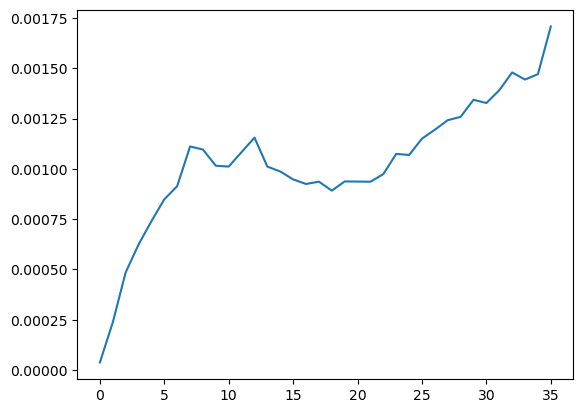

In [15]:
pd.Series(tstep_error).plot()

Comment:

This is the graph we expected - there is some obvious data-leakage here around the forecast horizon of 0 (since it was trained on this data) - but we see this decay in performance in time as would expect.

<AxesSubplot: >

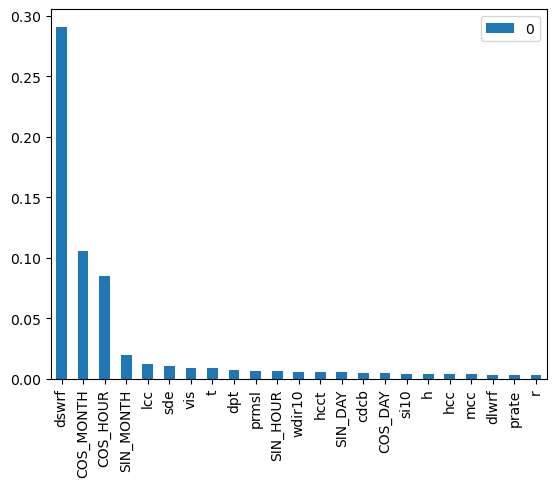

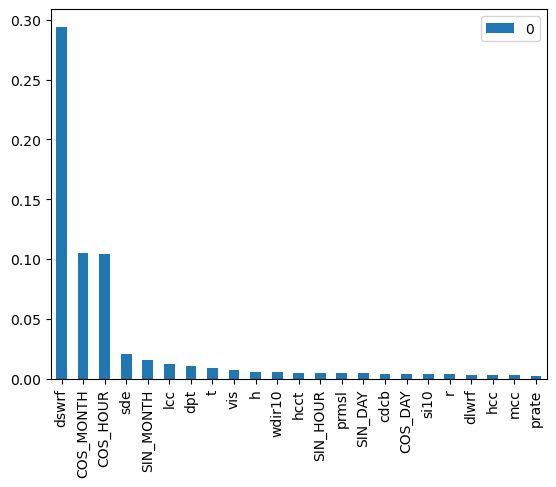

In [157]:
pd.DataFrame.from_dict(results[30].model.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False).plot.bar()
pd.DataFrame.from_dict(results[1].model.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False).plot.bar()

In [38]:
feature_importances_gain = pd.concat([pd.DataFrame.from_dict(results[x].model.get_booster().get_score(importance_type='gain'), orient="index", columns=[x]).T for x in results.keys()], axis=0)
feature_importances_weight = pd.concat([pd.DataFrame.from_dict(results[x].model.get_booster().get_score(importance_type='weight'), orient="index", columns=[x]).T for x in results.keys()], axis=0)
feature_importances_gain.head()

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,...,si10,wdir10,prmsl,prate,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR
0,0.004838,0.012171,0.003405,0.004838,0.016864,0.005228,0.297088,0.003348,0.005998,0.008388,...,0.004079,0.005110,0.004688,0.002485,0.011440,0.106512,0.004508,0.003641,0.004839,0.103942
1,0.003987,0.012538,0.003136,0.003159,0.020490,0.004965,0.294216,0.003217,0.005757,0.009111,...,0.003554,0.005170,0.004682,0.002544,0.015591,0.104696,0.004424,0.003952,0.004724,0.104453
2,0.003751,0.012471,0.003327,0.003097,0.022569,0.004539,0.278997,0.003245,0.005902,0.009489,...,0.003597,0.005214,0.004576,0.002941,0.015712,0.099543,0.004435,0.003809,0.004819,0.104085
3,0.004276,0.012098,0.003242,0.003083,0.014648,0.004079,0.280936,0.003123,0.005429,0.007023,...,0.003565,0.005890,0.004921,0.012533,0.012693,0.104248,0.004309,0.003499,0.005005,0.112785
4,0.004300,0.012495,0.003486,0.004007,0.013336,0.003933,0.278135,0.002874,0.004734,0.006411,...,0.003946,0.006512,0.005075,0.004879,0.011168,0.102334,0.004340,0.003511,0.004891,0.110284


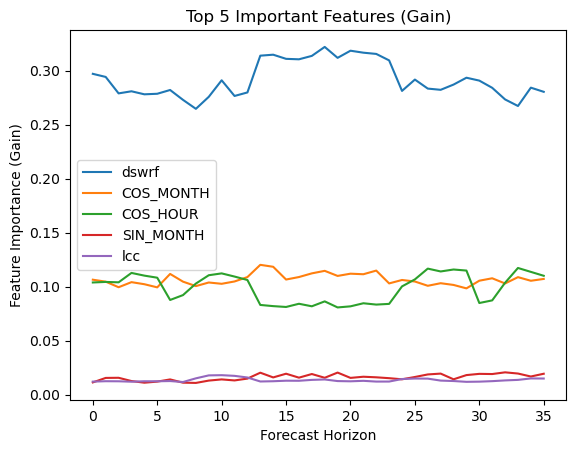

In [42]:
top5_avg_importance = feature_importances_gain.mean(axis=0).sort_values(ascending=False)[:5].index

plt.plot(feature_importances_gain[top5_avg_importance])
plt.title("Top 5 Important Features (Gain)")
plt.ylabel("Feature Importance (Gain)")
plt.xlabel("Forecast Horizon")
plt.legend(top5_avg_importance)
plt.show()

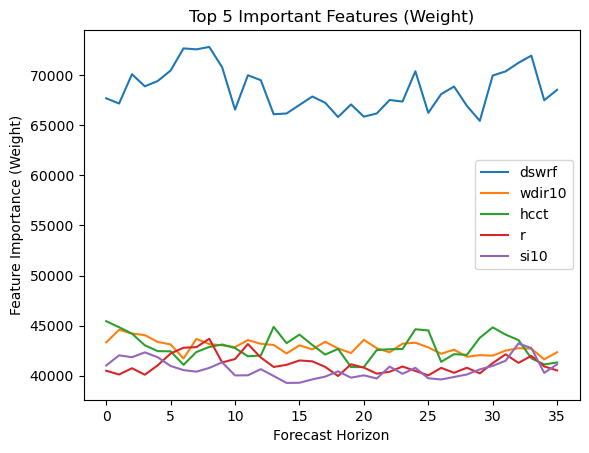

In [43]:
top5_avg_importance = feature_importances_weight.mean(axis=0).sort_values(ascending=False)[:5].index

plt.plot(feature_importances_weight[top5_avg_importance])
plt.title("Top 5 Important Features (Weight)")
plt.ylabel("Feature Importance (Weight)")
plt.xlabel("Forecast Horizon")
plt.legend(top5_avg_importance)
plt.show()